In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas
import streamlit_pandas_profiling
from pandas_profiling import ProfileReport
import streamlit as st
import shap
import bamboolib

# Load data

In [3]:
from pycaret.datasets import get_data
dataset = get_data('diamond')
dataset.shape

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


(6000, 8)

In [4]:
dataset

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


In [4]:
# dataset.to_csv('../data/raw/dummy_data.csv', index=False)

In [5]:
from pycaret.regression import *

In [6]:
def split_train_test(data, test_perc = 33, random_state = 42):
    '''Split data into training and testing datasets... validation data will be used from train 
    data itself during modeling.
    keep target variable intact in the data, setup method will automaticaly treat
    feature and target variables separately by specifying target name.
    
    param data: (pandas df) dataset
    param test_perc: (float) percentage of data to be used for testing
    param random_state: (int) (optional) set seed for reproducible split
    returns: (tuple) train_data and test_data '''
    #time.sleep(1)
    train_perc = (100 - test_perc)/100
    train_data = data.sample(frac=train_perc, random_state=random_state).reset_index(drop=True)
    test_data = data.drop(train_data.index).reset_index(drop=True)

    print('Data for Modeling: ' + str(train_data.shape))
    print('Unseen Data For Predictions ' + str(test_data.shape))
    return train_data, test_data

In [7]:
train_data, test_data = split_train_test(dataset)

Data for Modeling: (4020, 8)
Unseen Data For Predictions (1980, 8)


# Setup

In [8]:
# setup dictionary - to be forwarded as **kwargs in pr.setup() method
# add more required options
# expose documentation to UI -- what each keywords means (later)
setup_dict = {'data': train_data,
              'target' : 'Price', 
             'session_id':123, ### keep the session id fixed...across different experiments 
              #to see changes/improvements due to other parameters
             'normalize' : True,
             'transformation' : True,
             'transform_target' : True, 
             'combine_rare_levels' : True, 
             'rare_level_threshold' : 0.05,
             'remove_multicollinearity' : True,
             'multicollinearity_threshold' : 0.95,
             'bin_numeric_features' : ['Carat Weight']
             
             }

In [9]:
'''setup requires user confirmation- how to show on UI? 
the results of setup is pandas df- show on UI'''
reg_setup1 = setup(**setup_dict,silent=True)


 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,True
2,Transform Target Method,box-cox
3,Original Data,"(4020, 8)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,6
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


2020-08-21 16:56:11.744 INFO    logs: create_model_container: 0
2020-08-21 16:56:11.746 INFO    logs: master_model_container: 0
2020-08-21 16:56:11.746 INFO    logs: display_container: 0
2020-08-21 16:56:11.747 INFO    logs: setup() succesfully completed......................................


In [10]:
model_library = {'lr'       : 'Linear Regression',                   
                'lasso'    : 'Lasso Regression'   ,             
                'ridge'    : 'Ridge Regression'   ,            
                'en'       :' Elastic Net'          ,         
                'lar'      :' Least Angle Regression',                  
                'llar'     : 'Lasso Least Angle Regression',                   
                'omp'      : 'Orthogonal Matching Pursuit' ,                    
                'br'       : 'Bayesian Ridge '              ,    
                'ard'      : 'Automatic Relevance Determination',                  
                'par'      :' Passive Aggressive Regressor '     ,              
                'ransac'   : 'Random Sample Consensus '      ,
                'tr'       : 'TheilSen Regressor '            ,      
                'huber'    : 'Huber Regressor'                 ,              
                'kr'       : 'Kernel Ridge '                ,                    
                'svm'      : 'Support Vector Machine'   ,                        
                'knn'      : 'K Neighbors Regressor '  ,                        
                'dt'       : 'Decision Tree'     ,                               
                'rf'       : 'Random Forest '    ,                               
                'et'       : 'Extra Trees Regressor' ,                           
                'ada'      : 'AdaBoost Regressor ' ,                            
                'gbr'      : 'Gradient Boosting Regressor' ,                              
                'mlp'      : 'Multi Level Perceptron ',                         
                'xgboost'  : 'Extreme Gradient Boosting' ,                  
                'lightgbm' : 'Light Gradient Boosting' ,                   
                'catboost' : 'CatBoost Regressor' , 
                }

In [25]:
create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,890.9134,2964877.8947,1721.8821,0.9734,0.0901,0.0675
1,862.5744,2579939.5163,1606.2190,0.9697,0.0924,0.0689
2,878.4855,2300980.0069,1516.8982,0.9791,0.0877,0.0694
3,1199.9339,10066000.8648,3172.6962,0.9353,0.0996,0.0743
4,834.0219,3252576.4355,1803.4901,0.9704,0.0889,0.0622
5,881.1091,3269198.6125,1808.0925,0.9687,0.0854,0.0622
6,767.9972,1961346.1786,1400.4807,0.9774,0.0892,0.0652
7,909.2576,4732689.9688,2175.4747,0.9564,0.0980,0.0694
8,911.1134,3535629.4856,1880.3270,0.9649,0.0903,0.0680
9,864.7760,2255375.4956,1501.7908,0.9721,0.0915,0.0710


2020-08-21 22:04:23.329 INFO    logs: create_model_container: 5
2020-08-21 22:04:23.331 INFO    logs: master_model_container: 5
2020-08-21 22:04:23.333 INFO    logs: display_container: 6
2020-08-21 22:04:23.335 INFO    logs: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
2020-08-21 22:04:23.337 INFO    logs: create_model() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [11]:
results = compare_models(whitelist=['lr','rf'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Random Forest,900.0182,3691861.4459,1858.7351,0.9667,0.0913,0.0678,0.4874
1,Linear Regression,1025.8910,4842334.6587,2148.9519,0.9538,0.1529,0.0740,0.0174


2020-08-21 14:06:35.023 INFO    logs: create_model_container: 1
2020-08-21 14:06:35.024 INFO    logs: master_model_container: 1
2020-08-21 14:06:35.025 INFO    logs: display_container: 2
2020-08-21 14:06:35.028 INFO    logs: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
2020-08-21 14:06:35.030 INFO    logs: compare_models() succesfully completed......................................


In [23]:
# list(model_library.values()).index(['Linear Regression', 'Ridge Regression'])
model_to_build = ['rf']


In [24]:
top5 = compare_models(whitelist=model_to_build,n_select=5)
results = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Random Forest,900.0182,3691861.4459,1858.7351,0.9667,0.0913,0.0678,0.4825


2020-08-21 22:03:49.579 INFO    logs: create_model_container: 4
2020-08-21 22:03:49.580 INFO    logs: master_model_container: 4
2020-08-21 22:03:49.580 INFO    logs: display_container: 5
2020-08-21 22:03:49.583 INFO    logs: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
2020-08-21 22:03:49.584 INFO    logs: compare_models() succesfully completed......................................


In [10]:
import shap

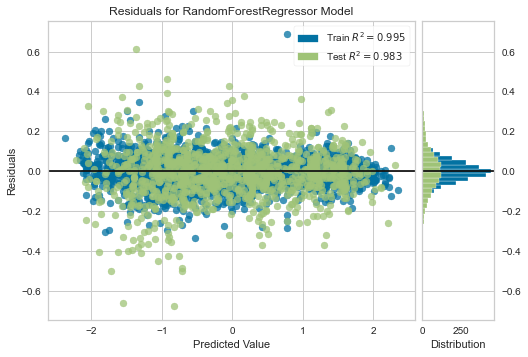

2020-08-21 16:55:03.180 INFO    logs: Visual Rendered Successfully
2020-08-21 16:55:03.226 INFO    logs: plot_model() succesfully completed......................................


In [12]:
rf = create_model('rf')
plot_model(rf)

In [52]:
results.Model.tolist()
results[:5]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,750.1578,2585007.5823,1552.1447,0.9758,0.0759,0.0560,2.3744
1,Extreme Gradient Boosting,829.9675,3067085.9382,1717.9512,0.9716,0.0831,0.0613,0.3560
2,Random Forest,900.0182,3691861.4459,1858.7351,0.9667,0.0913,0.0678,0.4820
3,Light Gradient Boosting Machine,856.9165,3816690.2511,1874.1451,0.9661,0.0823,0.0610,0.1679
4,Huber Regressor,1008.4321,4063255.8954,1996.6719,0.9612,0.0988,0.0732,0.1970
5,Ridge Regression,1008.8518,4091594.3480,2000.6471,0.9608,0.0985,0.0736,0.0095
6,Bayesian Ridge,1019.9218,4331915.6458,2052.3433,0.9584,0.0987,0.0737,0.0303
7,Extra Trees Regressor,1034.9384,4641473.3182,2096.9261,0.9576,0.1081,0.0799,0.4868
8,Decision Tree,1048.2539,4820424.1393,2136.2987,0.9560,0.1110,0.0815,0.0249
9,Support Vector Machine,957.7893,4857520.9616,2130.7347,0.9553,0.0909,0.0659,0.3594


2020-08-19 22:20:29.552 INFO    logs: create_model_container: 9
2020-08-19 22:20:29.553 INFO    logs: master_model_container: 9
2020-08-19 22:20:29.554 INFO    logs: display_container: 14
2020-08-19 22:20:29.561 INFO    logs: [<catboost.core.CatBoostRegressor object at 0x000001BD1C80EC18>, XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                     

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,750.1578,2.585008e+06,1552.1447,0.9758,0.0759,0.0560,2.3744
1,Extreme Gradient Boosting,829.9675,3.067086e+06,1717.9512,0.9716,0.0831,0.0613,0.3560
2,Random Forest,900.0182,3.691861e+06,1858.7351,0.9667,0.0913,0.0678,0.4820
3,Light Gradient Boosting Machine,856.9165,3.816690e+06,1874.1451,0.9661,0.0823,0.0610,0.1679
4,Huber Regressor,1008.4321,4.063256e+06,1996.6719,0.9612,0.0988,0.0732,0.1970


In [54]:
results.Model.tolist()

['CatBoost Regressor',
 'Extreme Gradient Boosting',
 'Random Forest',
 'Light Gradient Boosting Machine',
 'Huber Regressor',
 'Ridge Regression',
 'Bayesian Ridge',
 'Extra Trees Regressor',
 'Decision Tree',
 'Support Vector Machine',
 'Least Angle Regression',
 'Random Sample Consensus',
 'Linear Regression',
 'Gradient Boosting Regressor',
 'Passive Aggressive Regressor',
 'TheilSen Regressor',
 'AdaBoost Regressor',
 'K Neighbors Regressor',
 'Orthogonal Matching Pursuit',
 'Lasso Regression',
 'Elastic Net',
 'Lasso Least Angle Regression']

In [22]:
lr = create_model('dt')
# tm = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1108.5535,5763730.4447,2400.7771,0.9483,0.1197,0.0877
1,1031.1939,3833029.4736,1957.8124,0.9550,0.1114,0.0843
2,956.9227,2513493.8364,1585.4002,0.9771,0.1021,0.0802
3,1418.2572,11642633.3382,3412.1303,0.9251,0.1235,0.0899
4,998.5228,4779252.7802,2186.1502,0.9564,0.1073,0.0745
5,1003.7721,3838215.0071,1959.1363,0.9633,0.1028,0.0737
6,886.1482,2582989.6014,1607.1682,0.9703,0.1089,0.0789
7,1051.3207,5876114.7786,2424.0699,0.9459,0.1157,0.0841
8,1063.8823,4222400.6877,2054.8481,0.9580,0.1123,0.0833
9,963.9657,3152381.4453,1775.4947,0.9610,0.1067,0.0781


2020-08-21 22:02:30.990 INFO    logs: create_model_container: 3
2020-08-21 22:02:30.991 INFO    logs: master_model_container: 3
2020-08-21 22:02:30.992 INFO    logs: display_container: 3
2020-08-21 22:02:30.994 INFO    logs: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')
2020-08-21 22:02:30.996 INFO    logs: create_model() succesfully completed......................................


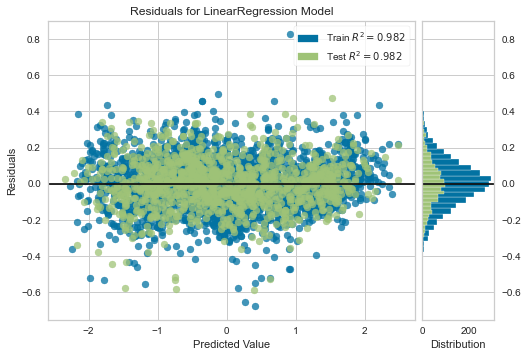

2020-08-19 23:02:54.649 INFO    logs: Visual Rendered Successfully
2020-08-19 23:02:54.651 INFO    logs: plot_model() succesfully completed......................................


In [63]:
p = plot_model(tm,verbose=False)

In [17]:
plot_library =  {'residuals'    :'Residuals Plot',
                    'error'         :'Prediction Error Plot',
                    'cooks'         :'Cooks Distance Plot'   ,                      
                    'rfe'           :'Recursive Feat. Selection',                     
                    'learning'      :'Learning Curve' ,                          
                    'vc'            :'Validation Curve',                               
                    'manifold'      :'Manifold Learning',                        
                    'feature'       :'Feature Importance',                        
                    'parameter'     :'Model Hyperparameter'
    }

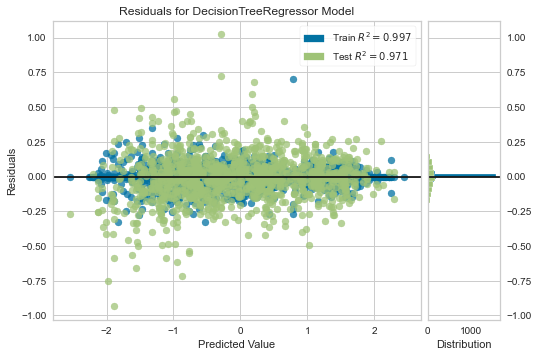

2020-08-21 17:02:10.102 INFO    logs: Visual Rendered Successfully
2020-08-21 17:02:10.143 INFO    logs: plot_model() succesfully completed......................................


In [21]:
plot_model(lr,)#, plot='reason')

In [19]:
interpret_model

True